In [1]:
import torch
import numpy as np
from os import walk
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [3]:
# dataset is here: smb://nas-weber01.unisg.ch/data/Nassy/03_Online_Model/features
_, _, file_names = next(walk('./dataset'))

files = [(name.split('_')[0], name.split('_')[1].split('.')[0], name) for name in file_names]

dataset = pd.DataFrame()

for (subject_number, task, file_name) in files:
    part = pd.read_csv(f'./dataset/{file_name}')
    labels = pd.read_csv(f'./labels/{subject_number}.csv', sep=";").set_index('task')
    rating = float(labels.loc[task]['r'])
    part['label'] = int(rating > 4)
    part['subject'] = subject_number

    dataset = pd.concat([part, dataset])
    
dataset.tail(80)

,subject,task,d_mean,d_median,d_std,e_min,e_max,e_mean,e_median,e_std,e_peak_count,e_peak_count_pm,b_min,b_max,b_mean,b_median,b_std,b_peak_count,b_peak_count_pm,label
0,003,t2,0.220919,0.259452,-0.088826,2.173757,3.732305,2.909432,2.888242,0.304057,113,30.678733,1.184541,3.732305,3.130351,3.147694,0.215231,71,35.500000,0
0,001,t8,0.644607,0.904941,-0.224034,2.798857,5.320766,4.003479,3.777844,0.522086,147,25.789474,0.622869,5.320766,4.648087,4.682785,0.298052,33,16.363636,0
0,003,t5,-0.015260,0.166744,0.346884,2.209762,3.790535,2.972422,2.975860,0.299366,93,27.623762,-0.104596,3.790535,2.957162,3.142604,0.646250,72,35.702479,0
0,005,t3,0.087266,0.028885,-0.076025,3.248507,4.961946,4.170758,4.238172,0.352659,79,32.689655,0.952023,4.961946,4.258024,4.267057,0.276634,67,33.223140,0
0,008,t2,0.503004,0.458838,-0.240136,2.819035,5.837738,3.880701,3.895067,0.659222,135,37.327189,1.178414,5.837738,4.383705,4.353905,0.419087,117,58.016529,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,005,t5,0.628790,0.897065,-0.344902,2.325528,5.208260,3.783169,3.531106,0.641257,159,39.750000,0.965752,5.208260,4.411959,4.428171,0.296355,110,55.000000,0
0,002,t2,0.326944,0.419992,-0.056302,2.622484,4.641601,3.524013,3.450530,0.356463,143,30.211268,1.946925,4.641601,3.850957,3.870521,0.300161,64,32.000000,1
0,002,t4,0.273119,0.244724,-0.150913,2.567246,4.814949,3.697906,3.746131,0.478354,102,35.375723,1.032171,4.814949,3.971025,3.990854,0.327441,83,41.500000,0
0,002,t6,0.469124,0.572494,-0.068472,2.393223,4.824264,3.476828,3.365062,0.404711,126,22.500000,0.214578,4.824264,3.945952,3.937556,0.336239,58,28.760331,1


In [4]:
TRAIN_FILTER = (~(dataset['task'] == 't7') & ~(dataset['subject'] == '007'))

data_train = dataset[~TRAIN_FILTER].drop(['subject', 'task', 'label'], axis=1).to_numpy()
data_test = dataset[TRAIN_FILTER].drop(['subject', 'task', 'label'], axis=1).to_numpy()

targets_train = dataset[~TRAIN_FILTER]['label'].to_numpy()
targets_test = dataset[TRAIN_FILTER]['label'].to_numpy()


In [5]:
# test shapes
print(data_train.shape)
print(targets_train.shape)
print(data_test.shape)
print(targets_test.shape)

(15, 17)
(15,)
(49, 17)
(49,)


In [6]:
## wrap data in dataset
# cast to tensor
data_train = torch.tensor(data_train).float()
targets_train = torch.tensor(targets_train).long()#.unsqueeze(dim=-1)
data_test = torch.tensor(data_test).float()
targets_test = torch.tensor(targets_test).long()#.unsqueeze(dim=-1)
# wrap in dataset class
dataset_train = torch.utils.data.TensorDataset(data_train, targets_train)
dataset_test = torch.utils.data.TensorDataset(data_test, targets_test)
# create dataloaders
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=10,shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=10,shuffle=True)

In [7]:
## create model
class NN(torch.nn.Module):
    def __init__(self, input_dimension,number_of_target_classes):
        super().__init__()
        # stack layers
        self.module_list = torch.nn.ModuleList()
        ## stacks contain of linear + nonlinear layers
        self.module_list.append(torch.nn.Linear(input_dimension,20))
        self.module_list.append(torch.nn.Tanh())
        #
        self.module_list.append(torch.nn.Linear(20,30))
        self.module_list.append(torch.nn.Tanh())
        #
        self.module_list.append(torch.nn.Linear(30,10))
        self.module_list.append(torch.nn.Tanh())
        # map to output layer
        self.module_list.append(torch.nn.Linear(10,number_of_target_classes))
    
    def forward(self,x):
        for module in self.module_list:
            x = module(x)
        return x

In [8]:
#instanciate model
model = NN(17,2)
#model.to(device)
# test forward pass
model(data_train[:10])

tensor([[-0.1967,  0.2130],
        [-0.1974,  0.2055],
        [-0.1691,  0.4124],
        [-0.0540,  0.2461],
        [-0.2016,  0.1782],
        [-0.1036,  0.3670],
        [-0.2010,  0.1813],
        [-0.2050,  0.1615],
        [-0.1847,  0.2038],
        [-0.2056,  0.1477]], grad_fn=<AddmmBackward>)

In [9]:
# def criterion and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)

In [10]:
# train
for epoch in range(2000):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = data
        inputs.to(device)
        targets.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        # 
        targets = targets.squeeze()
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 0:    # print every 2000 mini-batches
            #print("Training loss {} Steps: {}".format(running_loss / 1000, epoch * len(trainloader) + i))
            running_loss = 0.0


print('Finished Training')

Finished Training


new task
new participant
new task new participant

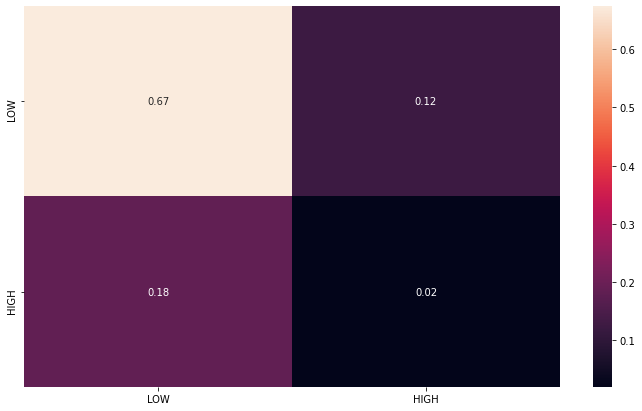

In [11]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = model(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('LOW', 'HIGH')
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix), index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('without-task-7-subject-7.png')

In [12]:
torch.save(model.state_dict(), './export/torch')

In [13]:
dataset

,subject,task,d_mean,d_median,d_std,e_min,e_max,e_mean,e_median,e_std,e_peak_count,e_peak_count_pm,b_min,b_max,b_mean,b_median,b_std,b_peak_count,b_peak_count_pm,label
0,003,t2,0.220919,0.259452,-0.088826,2.173757,3.732305,2.909432,2.888242,0.304057,113,30.678733,1.184541,3.732305,3.130351,3.147694,0.215231,71,35.500000,0
0,001,t8,0.644607,0.904941,-0.224034,2.798857,5.320766,4.003479,3.777844,0.522086,147,25.789474,0.622869,5.320766,4.648087,4.682785,0.298052,33,16.363636,0
0,003,t5,-0.015260,0.166744,0.346884,2.209762,3.790535,2.972422,2.975860,0.299366,93,27.623762,-0.104596,3.790535,2.957162,3.142604,0.646250,72,35.702479,0
0,005,t3,0.087266,0.028885,-0.076025,3.248507,4.961946,4.170758,4.238172,0.352659,79,32.689655,0.952023,4.961946,4.258024,4.267057,0.276634,67,33.223140,0
0,008,t2,0.503004,0.458838,-0.240136,2.819035,5.837738,3.880701,3.895067,0.659222,135,37.327189,1.178414,5.837738,4.383705,4.353905,0.419087,117,58.016529,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,005,t5,0.628790,0.897065,-0.344902,2.325528,5.208260,3.783169,3.531106,0.641257,159,39.750000,0.965752,5.208260,4.411959,4.428171,0.296355,110,55.000000,0
0,002,t2,0.326944,0.419992,-0.056302,2.622484,4.641601,3.524013,3.450530,0.356463,143,30.211268,1.946925,4.641601,3.850957,3.870521,0.300161,64,32.000000,1
0,002,t4,0.273119,0.244724,-0.150913,2.567246,4.814949,3.697906,3.746131,0.478354,102,35.375723,1.032171,4.814949,3.971025,3.990854,0.327441,83,41.500000,0
0,002,t6,0.469124,0.572494,-0.068472,2.393223,4.824264,3.476828,3.365062,0.404711,126,22.500000,0.214578,4.824264,3.945952,3.937556,0.336239,58,28.760331,1


In [14]:

right = 0
count = 0
with torch.no_grad():
    device = torch.device('cuda')
    model2 = NN(17,2)
    model2.load_state_dict(torch.load('./export/torch', map_location=device))
    model2.eval()

    for index in list(range(1, 64)):
        data_to_predict = dataset.drop(['subject', 'task', 'label'], axis=1).to_numpy()[index]

        prediction = model2(torch.from_numpy(data_to_predict).float())
        predicted_class = np.argmax(prediction)
        print(prediction, predicted_class, dataset.iloc[index]['label'], dataset.iloc[index]['subject'], dataset.iloc[index]['task'])
        right += 1 if predicted_class == dataset.iloc[index]['label'] else 0
        count += 1

print(right, count, right/count)


tensor([-1.9145,  2.4478]) tensor(1) 0 001 t8
tensor([ 0.6648, -0.6853]) tensor(0) 0 003 t5
tensor([ 0.6648, -0.6853]) tensor(0) 0 005 t3
tensor([ 0.6648, -0.6853]) tensor(0) 1 008 t2
tensor([-1.9145,  2.4479]) tensor(1) 0 001 t5
tensor([ 0.6648, -0.6853]) tensor(0) 1 008 t7
tensor([ 0.6648, -0.6853]) tensor(0) 1 002 t5
tensor([ 0.6648, -0.6853]) tensor(0) 0 005 t7
tensor([ 0.6648, -0.6853]) tensor(0) 0 003 t3
tensor([ 0.6648, -0.6853]) tensor(0) 1 002 t8
tensor([ 0.6648, -0.6853]) tensor(0) 0 008 t1
tensor([ 0.6646, -0.6851]) tensor(0) 0 003 t6
tensor([ 0.6648, -0.6853]) tensor(0) 0 004 t8
tensor([ 0.6645, -0.6851]) tensor(0) 0 006 t7
tensor([-1.9145,  2.4481]) tensor(1) 1 001 t7
tensor([ 0.6648, -0.6853]) tensor(0) 0 007 t1
tensor([ 0.6648, -0.6853]) tensor(0) 0 005 t4
tensor([ 0.6648, -0.6853]) tensor(0) 0 006 t3
tensor([ 0.6648, -0.6853]) tensor(0) 0 004 t3
tensor([ 0.6648, -0.6853]) tensor(0) 0 008 t4
tensor([ 0.6648, -0.6853]) tensor(0) 0 006 t8
tensor([ 0.6458, -0.6604]) tensor(

In [15]:
model# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])


Model's state_dict:
module_list.0.weight 	 torch.Size([20, 17])
module_list.0.bias 	 torch.Size([20])
module_list.2.weight 	 torch.Size([30, 20])
module_list.2.bias 	 torch.Size([30])
module_list.4.weight 	 torch.Size([10, 30])
module_list.4.bias 	 torch.Size([10])
module_list.6.weight 	 torch.Size([2, 10])
module_list.6.bias 	 torch.Size([2])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': tensor([[ 3.3472e-10,  4.1225e-10, -1.4525e-10,  3.2007e-09,  5.3844e-09,
          4.1221e-09,  4.0503e-09,  3.9661e-10,  5.0631e-08,  1.2450e-08,
          1.2871e-09,  5.3844e-09,  4.4568e-09,  4.4625e-09,  2.5136e-10,
          2.5965e-08,  1.2982e-08],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.0062e-08, -1.4696e-08,  1.8600e-08, -4.8114e-07, -8.3098e-07,
        